## Recommendation System II

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import pymongo
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
%matplotlib notebook

## Get reviews and synopsis

In [6]:
#Connections with mongoDB collections
client = pymongo.MongoClient("mongodb://localhost:27017/")
mi_db = client["books"]

revsColec = mi_db["reviews"]
revsMetaColec = mi_db["revsmetadata"]
booksMetaColec = mi_db["booksmetadata"]

In [7]:
#Load revisions into DataFrame
revsMetaDF = pd.DataFrame(revsMetaColec.find())
emoDict = revsMetaDF['revEmo'].values
emoList = emoDict.tolist()
emoDF = pd.DataFrame(emoList)
emoAvgDF = emoDF.div(emoDF.sum(axis=1), axis=0).fillna(0)
revsMetaDF = pd.concat([revsMetaDF.loc[:, revsMetaDF.columns != 'revEmo'], emoAvgDF], axis = 1).sort_values(['bookID', 'userID'])
revsMetaDF.iloc[:5,]

,_id,userID,bookID,revSent,revSubj,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
9530,3266054823,107601413,1,0.700000,0.600000,0.0,0.200000,0.0,0.0,0.200000,0.0,0.200000,0.0,0.200000,0.200000
10294,3266695962,27488741,1,0.400000,0.625000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
9501,3266043633,67012921,1,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
5793,3259466750,93669131,1,0.716667,0.566667,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.000000
11120,4000000001,10000001,10000001,0.353485,0.601364,0.0,0.142857,0.0,0.0,0.142857,0.0,0.428571,0.0,0.071429,0.214286


In [8]:
#Exclude revisions according to an alpha value
alpha = 1
maskRevs1 = revsMetaDF['revSent']< 0
maskRevs2 = revsMetaDF['positive']-revsMetaDF['negative'] > 0
maskRevs3 = (revsMetaDF['positive']- revsMetaDF['negative'])/(alpha * -revsMetaDF['revSent']) < 1 
revsMetaDF = revsMetaDF[~(maskRevs1 & maskRevs2 & maskRevs3)]
revsMetaDF.iloc[:5,:]

,_id,userID,bookID,revSent,revSubj,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
9530,3266054823,107601413,1,0.700000,0.600000,0.0,0.200000,0.0,0.0,0.200000,0.0,0.200000,0.0,0.200000,0.200000
10294,3266695962,27488741,1,0.400000,0.625000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
9501,3266043633,67012921,1,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
5793,3259466750,93669131,1,0.716667,0.566667,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.000000
11120,4000000001,10000001,10000001,0.353485,0.601364,0.0,0.142857,0.0,0.0,0.142857,0.0,0.428571,0.0,0.071429,0.214286


In [9]:
#Load synopsis into DataFrame 
booksMetaDF = pd.DataFrame(booksMetaColec.find())
emoDict = booksMetaDF['descrEmo'].values
emoList = emoDict.tolist()
emoDF = pd.DataFrame(emoList)
emoAvgDF = emoDF.div(emoDF.sum(axis=1), axis=0).fillna(0)
booksMetaDF = pd.concat([booksMetaDF.loc[:, booksMetaDF.columns != 'descrEmo'], emoAvgDF], axis = 1).sort_values('_id')
booksMetaDF.iloc[:5,]

,_id,descrSent,descrSubj,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
5161,1,0.016425,0.677778,0.112000,0.072000,0.064000,0.088000,0.024000,0.216000,0.136000,0.136000,0.064000,0.088000
924,1001506,-0.125000,0.375000,0.066667,0.066667,0.066667,0.066667,0.133333,0.066667,0.200000,0.066667,0.066667,0.200000
5327,1002520,0.300000,1.000000,0.133333,0.100000,0.033333,0.133333,0.066667,0.133333,0.100000,0.133333,0.000000,0.166667
2599,10032454,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5277,1003759,0.218750,0.631250,0.000000,0.111111,0.055556,0.055556,0.166667,0.111111,0.277778,0.000000,0.055556,0.166667


## Define metrics for the system

In [11]:
#Cosene distance
def cos(DF1, id1, DF2, id2):
    
    order = ['anger','disgust','sadness','surprise','fear','trust', 'joy','anticipation']
    arr1 = DF1[DF1['_id'] == id1][order].squeeze()
    arr2 = DF2[DF2['_id'] == id2][order].squeeze()
    return arr1.dot(arr2) / (arr1.dot(arr1)*arr2.dot(arr2))**0.5

cos(revsMetaDF, '3266054823', revsMetaDF, '3252865587')

0.5

In [12]:
#Euclidian distance
def distEuc(DF1, id1, DF2, id2):
    
    order = ['anger','disgust','sadness','surprise','fear','trust', 'joy','anticipation']
    arr1 = DF1[DF1['_id'] == id1][order].squeeze()
    arr2 = DF2[DF2['_id'] == id2][order].squeeze()
    dif = arr1 - arr2
    return dif.dot(dif)**0.5

distEuc(revsMetaDF, '3266054823', revsMetaDF, '3252865587')

0.45825756949558405

In [13]:
#Pearson correlation distance
def pearson(DF1, id1, DF2, id2):
    
    order = ['anger','disgust','sadness','surprise','fear','trust', 'joy','anticipation']
    arr1 = DF1[DF1['_id'] == id1][order].squeeze()
    arr2 = DF2[DF2['_id'] == id2][order].squeeze()
    return np.corrcoef(arr1, arr2)[0, 1]

pearson(revsMetaDF, '3266054823', revsMetaDF, '3252865587')

0.3779644730092272

In [14]:
#Gets a given metric for two texts
def metric(DF1, id1, DF2, id2, metr):
    if metr == 'pearson':
        return pearson(DF1, id1, DF2, id2)
    elif metr == 'distEuc':
        return distEuc(DF1, id1, DF2, id2)
    else:
        return cos(DF1, id1, DF2, id2)

## Study of the behaviour of the metrics in the corpus

In [11]:
#Metrics behaviour in the dataset for n ramdom couples of revisions and synopsis
n = 100

lon = len(revsMetaDF)
indexes1 = np.random.randint(lon, size = n)
indexes2 = np.random.randint(lon, size = n)

revsCos = [cos(revsMetaDF, revsMetaDF.iloc[ind1]['_id'], revsMetaDF, revsMetaDF.iloc[ind2]['_id'])
            for ind1 in indexes1 for ind2 in indexes2]
revsDistEuc = [distEuc(revsMetaDF, revsMetaDF.iloc[ind1]['_id'], revsMetaDF, revsMetaDF.iloc[ind2]['_id'])
            for ind1 in indexes1 for ind2 in indexes2]
revsPearson = [pearson(revsMetaDF, revsMetaDF.iloc[ind1]['_id'], revsMetaDF, revsMetaDF.iloc[ind2]['_id'])  
            for ind1 in indexes1 for ind2 in indexes2]

indexes3 = np.random.randint(len(booksMetaDF), size = n)

booksCos = [cos(revsMetaDF, revsMetaDF.iloc[ind1]['_id'], booksMetaDF, booksMetaDF.iloc[ind3]['_id'])
            for ind1 in indexes1 for ind3 in indexes3]
booksDistEuc = [distEuc(revsMetaDF, revsMetaDF.iloc[ind1]['_id'], booksMetaDF, booksMetaDF.iloc[ind3]['_id'])
            for ind1 in indexes1 for ind3 in indexes3]
booksPearson = [pearson(revsMetaDF, revsMetaDF.iloc[ind1]['_id'], booksMetaDF, booksMetaDF.iloc[ind3]['_id'])  
            for ind1 in indexes1 for ind3 in indexes3]

metricsCompDF = pd.DataFrame()
metricsCompDF['Revision-Revision'] = [ np.nanmean( revsCos ), np.nanmean(revsDistEuc), np.nanmean(revsPearson) ]
metricsCompDF['Revision-Synopsis'] = [ np.nanmean( booksCos ), np.nanmean(booksDistEuc), np.nanmean(booksPearson) ]    
metricsCompDF.index=['cos', 'distEuc', 'Pearson'] 

errDF = pd.DataFrame()
errDF['Revs']=[np.nanstd(revsCos)*(1.98/(n**0.5)), np.nanstd(revsDistEuc)*(1.98/(n**0.5)), 
        np.nanstd(revsPearson)*(1.98/(n**0.5))]
errDF['Books'] = [ np.nanstd(booksCos)*(1.98/(n**0.5)), np.nanstd(booksDistEuc)*(1.98/(n**0.5)), 
        np.nanstd(booksPearson)*(1.98/(n**0.5))]
errDF.index = ['cos', 'distEuc', 'Pearson'] 

print('n=', n)
print(metricsCompDF)
print(errDF)

C:\Users\NITROPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\NITROPC\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\NITROPC\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


n= 100
         Revision-Revision  Revision-Synopsis
cos               0.521628           0.605620
distEuc           0.350306           0.291813
Pearson           0.191437           0.186797
             Revs     Books
cos      0.058319  0.049389
distEuc  0.043360  0.031865
Pearson  0.092500  0.093390


<IPython.core.display.Javascript object>


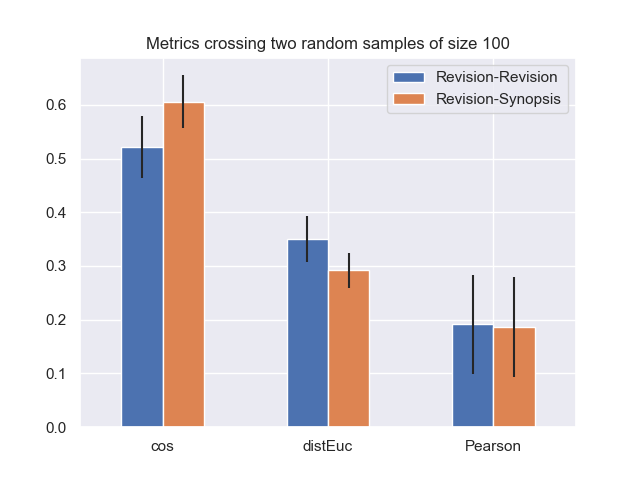

In [12]:
metricsCompDF.plot(kind = 'bar', yerr=[errDF['Revs'], errDF['Books']], rot=0, title='Metrics crossing two random samples of size 100')

<IPython.core.display.Javascript object>


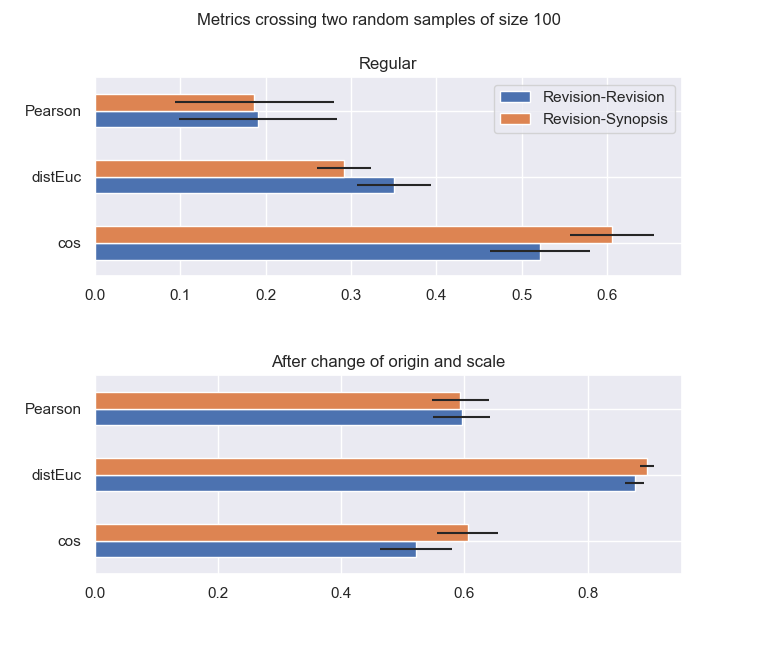

In [13]:
#Apllying change og origin and scale
fig , axes = plt.subplots(2, 1)
fig.suptitle('Metrics crossing two random samples of size 100')
metricsCompDF.plot(ax = axes[0], kind = 'barh', xerr=[errDF['Revs'], errDF['Books']], rot=0, title='Regular')
plt.rc('legend',fontsize=8)
OEmetricsCompDF = metricsCompDF.T
OEmetricsCompDF['distEuc'] =  1- (OEmetricsCompDF['distEuc'])/2.83
OEmetricsCompDF['Pearson'] = (1 + OEmetricsCompDF['Pearson'])*0.5
OEerrDF = errDF.T
OEerrDF['distEuc'] = OEerrDF['distEuc']/2.83
OEerrDF['Pearson'] = 0.5*OEerrDF['Pearson'] 
#axes[0].legend(loc=4)
OEmetricsCompDF.T.plot(ax = axes[1], kind = 'barh', xerr=[OEerrDF.T['Revs'], OEerrDF.T['Books']], 
                       rot=0, title='After change of origin and scale', legend=False)
plt.subplots_adjust(hspace=0.5)

<IPython.core.display.Javascript object>


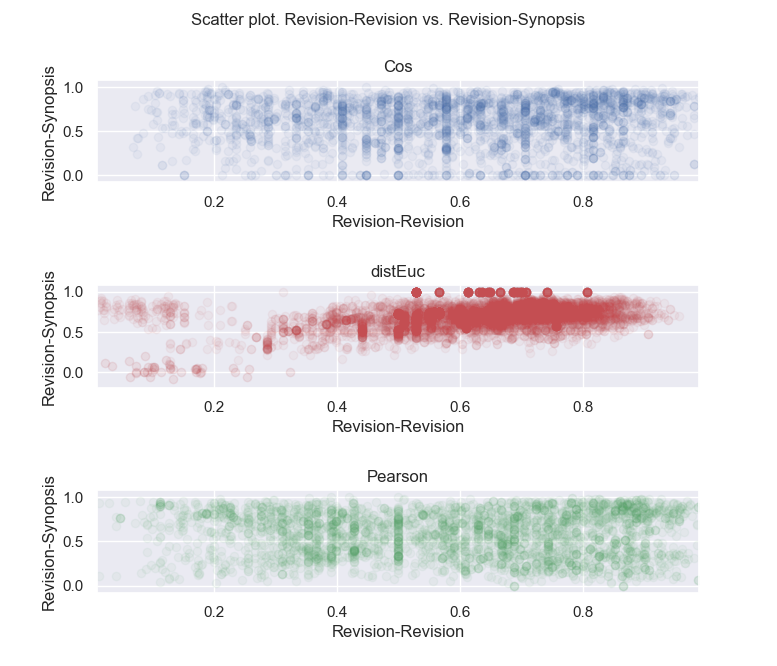

C:\Users\NITROPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  # Remove the CWD from sys.path while we load stuff.


In [14]:
#Scatter plor. Metriccs for Revisions-Revisions and Revisions-Synopsis
fig , axes = plt.subplots(3, 1)
fig.suptitle('Scatter plot. Revision-Revision vs. Revision-Synopsis')


axes[0].title.set_text('Cos')
axes[0].set_xlabel('Revision-Revision')
axes[0].set_ylabel('Revision-Synopsis')
axes[0].set_xlim(0.01, 0.99)
#axes[0].set_ylim(0.1)
axes[0].scatter(revsCos, booksCos, color = 'B', alpha = 0.05)

axes[1].title.set_text('distEuc')
axes[1].set_xlabel('Revision-Revision')
axes[1].set_ylabel('Revision-Synopsis')
axes[1].set_xlim(0.01, 0.99)
#axes[1].set_ylim(0.1)
OErevsDistEuc = [ 1 - item for item in revsDistEuc]
OEbooksDistEuc = [1 - item for item in booksDistEuc]
axes[1].scatter(OErevsDistEuc, OEbooksDistEuc, color = 'r', alpha = 0.05)

axes[2].title.set_text('Pearson')
axes[2].set_xlabel('Revision-Revision')
axes[2].set_ylabel('Revision-Synopsis')
axes[2].set_xlim(0.01, 0.99)
OErevsPearson = [ (1 + item)*0.5 for item in revsPearson]
OEbooksPearson = [ (1 + item)*0.5 for item in booksPearson]
axes[2].scatter(OErevsPearson, OEbooksPearson, color = 'g', alpha = 0.05)

plt.subplots_adjust(hspace=1)

## Get recommended explanations

In [17]:
#Get explanation sentence for a recommendation
def getExplanation(readBookID, readAuthorID, emo1, emo2, recBookID, recAuthorID):
    
    emosDict = {'anger': 'anger', 'disgust': 'disgust', 'sadness': 'sadness', 'surprise': 'surprise', 'fear': 'fear', 
              'trust': 'trust',  'joy': 'joy','anticipation': 'anticipation'}
    sentences = [
        'You enjoyed reading %s by %s and feeling %s and %s. So, you could read %s by %s',
        'If you want to feel again the %s and %s that you felt reading %s by %s, consider reading %s by %s',
        'Reading %s by %s, you can have the same experience of %s and %s that you had reading %s by %s.',
        'In %s by %s you can have as much %s and %s as you had in %s %s ',
        'Didn\'t you have enough %s and %s with %s by %s? Go for %s by %s'
            ]
    orders = [
            (readBookID, readAuthorID, emosDict[emo1], emosDict[emo2], recBookID, recAuthorID ),
            (emosDict[emo1], emosDict[emo2], readBookID, readAuthorID, recBookID, recAuthorID ),
            (recBookID, recAuthorID, emosDict[emo1], emosDict[emo2], readBookID, readAuthorID),
            (recBookID, recAuthorID, emosDict[emo1], emosDict[emo2], readBookID, readAuthorID),
            (emosDict[emo1], emosDict[emo2], readBookID, readAuthorID, recBookID, recAuthorID )
            ]
    
    while True:
        ind = np.random.randint(len(sentences), size=1)[0]
        if ind not in indList:
            indList.append(ind)
            break
    print(sentences[ind] % orders[ind])
    return sentences[ind] % orders[ind]

### From user's reviews

In [23]:
#Get explained recommendations from reviews
def getRecsRevs(userID, threshold, met='cos'):

    #number of recoommendations to get
    number_recs = 5
    #Get recommendations
    userDF = revsMetaDF[revsMetaDF['userID']== userID]
    userRevIDs = userDF['_id']
    lista = []
    while len(lista) < number_recs:
        ind2 = np.random.randint(len(revsMetaDF), size = 1)[0]
        revID2 = revsMetaDF.iloc[ind2]['_id']
        ind1 = np.random.randint(len(userDF), size = 1)[0]
        revID1 = userDF.iloc[ind1]['_id']
        if revID2 in userRevIDs: continue
        met_val = metric(revsMetaDF, revID1, revsMetaDF, revID2, met)
        if met_val != met_val: continue
        if met == 'distEuc':
            if met_val <= threshold:
                lista.append([revID1, revID2, met_val])   
        else:
            if met_val >= threshold:
                lista.append([revID1, revID2, met_val])           
        print('Reader revID:', revID1, 'Recommender revID:', revID2, 'Metric:', met_val)
    print(lista)
    #Get info from recommendations
    resultDF = pd.DataFrame()
    i = 0
    for item in lista:
        book = revsColec.find_one({'_id': item[1]}, 
                            {'userID': 1, 'bookID': 1, 'bookTile': 1, 'bookAuthorName': 1})
        user_info = revsColec.find_one({'_id': item[0]}, {'bookTile': 1, 'bookAuthorName': 1})
        
        maxEmos = revsMetaDF.loc[revsMetaDF['_id']== item[1]] [['anger','disgust','sadness','surprise','fear','trust', 
                    'joy','anticipation']].squeeze().sort_values(ascending=False)[:2].index
        
        explan = getExplanation( user_info['bookTile'], user_info['bookAuthorName'], maxEmos[0], maxEmos[1], 
                    book['bookTile'], book['bookAuthorName'] )
         
        resultDF[i] = [item[0], user_info['bookTile'],user_info['bookAuthorName'], item[1],
                        book['bookID'], book['bookTile'], book['bookAuthorName'], item[2], explan]

        i += 1
    resultDF = resultDF.T
    resultDF.columns = ['userReadingID', 'userReadingTitle','userReadingAuthor','revID','bookRecomID', 'bookRecomTitle', 
                        'bookRecomAuthor', met, 'Explanation']
    return resultDF.sort_values(met, ascending = False)

In [19]:
indList=[]
getRecsRevs('108877532', 0.8, 'cos')

C:\Users\NITROPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


Reader revID: 3254514931 Recommender revID: 3252766499 Metric: 0.7905694150420949
Reader revID: 3254528112 Recommender revID: 3266327746 Metric: 0.8084520834544432
Reader revID: 3254514931 Recommender revID: 3257620608 Metric: 0.15811388300841897
Reader revID: 3254514931 Recommender revID: 3254244867 Metric: 0.8944271909999159
Reader revID: 3254528112 Recommender revID: 3261463550 Metric: 0.8333333333333334
Reader revID: 3254514931 Recommender revID: 3267657226 Metric: 0.0
Reader revID: 3254514931 Recommender revID: 3252584754 Metric: 0.5477225575051661
Reader revID: 3254514931 Recommender revID: 3256644209 Metric: 0.6324555320336759
Reader revID: 3254514931 Recommender revID: 3267493278 Metric: 0.18257418583505536
Reader revID: 3254514931 Recommender revID: 3259918896 Metric: 0.565685424949238
Reader revID: 3254514931 Recommender revID: 3262620646 Metric: 0.7267220926874316
Reader revID: 3254528112 Recommender revID: 3262283761 Metric: 0.5685352436149611
Reader revID: 3254514931 Recom

,userReadingID,userReadingTitle,userReadingAuthor,revID,bookRecomID,bookRecomTitle,bookRecomAuthor,cos,Explanation
1,3254514931,My Friend Suhana,Shaila M. Abdullah,3254244867,357486,Voices from Chernobyl: The Oral History of a N...,Svetlana Alexievich,0.894427,Didn't you have enough joy and trust with My F...
3,3254514931,My Friend Suhana,Shaila M. Abdullah,3252423364,48730976,"Logan: King of fools, T1",Sissie Roy,0.843274,"Reading Logan: King of fools, T1 by Sissie Roy..."
2,3254528112,Brune,Håkon Øvreås,3261463550,48894912,"The Lost Legends (The Nihryst, #1)",Cait Marie,0.833333,You enjoyed reading Brune by Håkon Øvreås and ...
4,3254528112,Brune,Håkon Øvreås,3264927544,30556459,The Twelve Lives of Samuel Hawley,Hannah Tinti,0.833333,In The Twelve Lives of Samuel Hawley by Hannah...
0,3254528112,Brune,Håkon Øvreås,3266327746,49050946,Checked Out for Murder (The Haunted Library My...,Allison Brook,0.808452,If you want to feel again the joy and sadness ...


### From synopsis of the books

In [24]:
#Get explained recommendations from a synopsis
ef getRecsBooks(userID, threshold, met='cos'):
    
    #number of recoommendations to get
    number_recs = 5
    #Get recommendations
    userDF = revsMetaDF[revsMetaDF['userID']== userID]
    userBooksIDs = userDF['bookID']
    lista = []
    while len(lista) < number_recs:
        ind2 = np.random.randint(len(booksMetaDF), size = 1)[0]
        revID2 = booksMetaDF.iloc[ind2]['_id']
        ind1 = np.random.randint(len(userDF), size = 1)[0]
        revID1 = userDF.iloc[ind1]['_id']
        if revID2 in userBooksIDs: continue
        met_val = metric(revsMetaDF, revID1, booksMetaDF, revID2, met)
        if met_val != met_val: continue
        if met == 'distEuc':
            if met_val <= threshold:
                lista.append([revID1, revID2, met_val])   
        else:
            if met_val >= threshold:
                lista.append([revID1, revID2, met_val])           
        print('Reader revID:', revID1, 'Recommender revID:', revID2, 'Metric:', met_val)
    print(lista)
    #Get info from recommendations
    resultDF = pd.DataFrame()
    i = 0
    for item in lista:
        book = revsColec.find_one({'bookID': item[1]}, 
                            {'userID': 1, 'bookID': 1, 'bookTile': 1, 'bookAuthorName': 1})
        user_info = revsColec.find_one({'_id': item[0]}, {'bookTile': 1, 'bookAuthorName': 1})
        
        maxEmos = booksMetaDF.loc[booksMetaDF['_id']== item[1]] [['anger','disgust','sadness','surprise','fear','trust', 
                    'joy','anticipation']].squeeze().sort_values(ascending=False)[:2].index
        
        explan = getExplanation( user_info['bookTile'], user_info['bookAuthorName'], maxEmos[0], maxEmos[1], 
                    book['bookTile'], book['bookAuthorName'] )
         
        resultDF[i] = [item[0], user_info['bookTile'],user_info['bookAuthorName'], 
                       item[1], book['bookTile'], book['bookAuthorName'], item[2], explan]

        i += 1
    resultDF = resultDF.T
    resultDF.columns = ['userReadingID', 'userReadingTitle','userReadingAuthor', 'bookRecomID', 'bookRecomTitle', 
                        'bookRecomAuthor', met, 'Explanation']
    return resultDF.sort_values(met, ascending = False)

In [25]:
indList=[]
getRecsBooks('108877532', 0.8, 'cos')

Reader revID: 3254514931 Recommender revID: 48932349 Metric: 0.628151732673064
Reader revID: 3254528112 Recommender revID: 40697008 Metric: 0.9001808023903551
Reader revID: 3254528112 Recommender revID: 23906424 Metric: 0.3333333333333333
Reader revID: 3254528112 Recommender revID: 38980 Metric: 0.7705289916987291
Reader revID: 3254528112 Recommender revID: 34334799 Metric: 0.8660254037844386
Reader revID: 3254514931 Recommender revID: 13497818 Metric: 0.5939696961966999
Reader revID: 3254514931 Recommender revID: 51551014 Metric: 0.3872983346207417


C:\Users\NITROPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


Reader revID: 3254514931 Recommender revID: 42774128 Metric: 0.8141546477834324
Reader revID: 3254514931 Recommender revID: 52008972 Metric: 0.7564805177416187
Reader revID: 3254528112 Recommender revID: 48487370 Metric: 0.8415259932542927
Reader revID: 3254514931 Recommender revID: 8518400 Metric: 0.22360679774997896
Reader revID: 3254514931 Recommender revID: 36402304 Metric: 0.8365345557603139
[['3254528112', '40697008', 0.9001808023903551], ['3254528112', '34334799', 0.8660254037844386], ['3254514931', '42774128', 0.8141546477834324], ['3254528112', '48487370', 0.8415259932542927], ['3254514931', '36402304', 0.8365345557603139]]
Didn't you have enough anticipation and joy with Brune by Håkon Øvreås? Go for A Match Made in Mehendi by Nandini Bajpai
In Find Me by Micaela Vee you can have as much joy and trust as you had in Brune Håkon Øvreås 
If you want to feel again the trust and anticipation that you felt reading My Friend Suhana by Shaila M. Abdullah, consider reading Lonely Plan

,userReadingID,userReadingTitle,userReadingAuthor,bookRecomID,bookRecomTitle,bookRecomAuthor,cos,Explanation
0,3254528112,Brune,Håkon Øvreås,40697008,A Match Made in Mehendi,Nandini Bajpai,0.900181,Didn't you have enough anticipation and joy wi...
1,3254528112,Brune,Håkon Øvreås,34334799,Find Me,Micaela Vee,0.866025,In Find Me by Micaela Vee you can have as much...
3,3254528112,Brune,Håkon Øvreås,48487370,The Memory Wood,Sam Lloyd,0.841526,"Reading The Memory Wood by Sam Lloyd, you can..."
4,3254514931,My Friend Suhana,Shaila M. Abdullah,36402304,Can't Buy Me Love,Abigail Drake,0.836535,You enjoyed reading My Friend Suhana by Shaila...
2,3254514931,My Friend Suhana,Shaila M. Abdullah,42774128,Lonely Planet Best of Iceland,Lonely Planet,0.814155,If you want to feel again the trust and antici...
